# INSTALLING STYLEGAN2-ADA-PYTORCH from NVIDIA


* [Training Generative Adversarial Networks with Limited Data](https://arxiv.org/abs/2006.06676)
Tero Karras, Miika Aittala, Janne Hellsten, Samuli Laine, Jaakko Lehtinen, Timo Aila
* [One millisecond face alignment with an ensemble of regression trees](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf) Vahid Kazemi, Josephine Sullivan


In [ ]:
import sys
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

In [ ]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

# Setting the global variables
NETWORK for dataset (you can use the metfaces.pkl and the ffhq.pkl for this example
FPS frames per second
FREEZE_STEPS 30 seconds for the video
"https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl"
"https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

In [ ]:
NETWORK = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

# Source image: Uploading a square 1024 x 1024 pixel Source image

In [ ]:
import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload square file 1024 x 1024 for the source image.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    SOURCE_NAME = f"source{ext}"
    open(SOURCE_NAME, 'wb').write(v)

Saving movie (2)_Moment.jpg to movie (2)_Moment.jpg


# Target image: Uploading a square 1024 x 1024 pixel Target image

In [ ]:
import os
from google.colab import files

uploaded = files.upload()

if len(uploaded) != 1:
  print("Upload square file 1024 x 1024 for the source image.")
else:
  for k, v in uploaded.items():
    _, ext = os.path.splitext(k)
    os.remove(k)
    TARGET_NAME = f"target{ext}"
    open(TARGET_NAME, 'wb').write(v)

Saving seed-6412.png to seed-6412.png


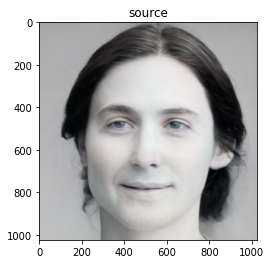

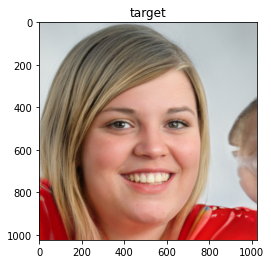

True

In [ ]:
from matplotlib import pyplot as plt
import cv2
from PIL import Image
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)
  
  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  crop1 = left_eye2[0] - 385 
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

# Projecting images to latent space (this will take several minutes)

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_source --target=cropped_source.png --network={NETWORK}"
!{cmd}

In [ ]:
cmd = f"python /content/stylegan2-ada-pytorch/projector.py --save-video 0 --num-steps 1000 --outdir=out_target --target=cropped_target.png --network={NETWORK}"
!{cmd}

# Load the source and target latent vectors to a video

In [ ]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio as imageio_ffmpeg
import imageio
from tqdm.notebook import tqdm
!pip install imageio-ffmpeg
lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')
#!ffmpeg -r 30 -i /content/results/direction-%d.png -vcodec mpeg4 -y movie
for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
   
  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

In [ ]:
from google.colab import files
files.download("movie.mp4") 

In [ ]:
# Style mixing example
cmd = f"python /content/stylegan2-ada-pytorch/style_mixing.py --outdir=out --rows=85,100,75,458,1500 --cols=55,821,1789,293 \
    --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl"...
Generating W vectors...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Generating images...
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating style-mixed images...
Saving images...
Saving image grid...
